# Load modules

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 952kB 15.3MB/s 
     |████████████████████████████████| 37.6MB 87kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import torch
import time
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from IPython.display import clear_output

In [ ]:
A.__version__

'0.5.2'

In [ ]:
cv2.__version__

'4.5.1'

In [ ]:
# Image config
IMAGE_SIZE = [192, 192]
HEATMAP_SIZE = [48, 48]
NUM_JOINTS = 21

# Augmentation config
FLIP_DATA = True
SCALE_FACTOR = 0.25
ROT_FACTOR = 30

# Training config
BEGIN_EPOCH = 0
END_EPOCH = 140
BATCH_SIZE = 16
MOMENTUM = 0.9
LEARNING_RATE = 1e-4
GAMMA_1 = 0.99
GAMMA_2 = 0.0
BN_MOMENTUM = 0.1

In [ ]:
# Colors for keypoints
point_colors = [[250, 0, 0],
               [200, 0, 0],
               [150, 0, 0],
               [100, 0, 0],
               [50, 0, 0],
               [250, 250, 250],
               [200, 200, 200],
               [150, 150, 150],
               [100, 100, 100],
               [0, 250, 0],
               [0, 200, 0],
               [0, 150, 0],
               [0, 100, 0],
               [0, 250, 250],
               [0, 200, 200],
               [0, 150, 150],
               [0, 100, 100],
               [0, 0, 250],
               [0, 0, 200],
               [0, 0, 150],
               [0, 0, 100]]

# Colors for keypoint connecting lines 
line_colors = [[250, 0, 0],
              [200, 0, 0],
              [150, 0, 0],
              [100, 0, 0],
              [250, 0, 0],
              [200, 200, 200],
              [150, 150, 150],
              [100, 100, 100],
              [250, 0, 0],
              [0, 200, 0],
              [0, 150, 0],
              [0, 100, 0],
              [250, 0, 0],
              [0, 200, 200],
              [0, 150, 150],
              [0, 100, 100],
              [250, 0, 0],
              [0, 0, 200],
              [0, 0, 150],
              [0, 0, 100]]

# Indices of keypoint pairs for connection
connection_indices = [[0,1], [1,2], [2,3], [3,4],
                      [0,5], [5,6], [6,7], [7,8],
                      [0,9], [9,10], [10,11], [11,12],
                      [0,13], [13,14], [14,15], [15,16],
                      [0,17], [17,18], [18,19], [19,20]]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

## Functions for dataset loading

In [ ]:
def get_info(data):

  '''
  Read int and float numbers from str line
  Input:
    - data - column as numpy array from .csv table
  Output:
    - new_data - list of lists with int and float numbers (bbox coords or keypoint coords)
  '''

  new_data = []
  for i in range(len(data)):
    example = [float(x.strip()) if '.' in x else int(x.strip()) for x in data[i][1:-1].split(',')]
    new_data.append(example)

  return new_data 

In [ ]:
def correct_visibility(keypoints):

  '''
  Split keypoints from .csv table to keypoints and visibility flags
  Change various types of visibility representation (float and int) to 0 and 1
  Input:
    - keypoints - 21 * 3 elements numpy array
  Output:
    - fixed_keypoints - numpy array with keypoints coords (21 * [x, y])
    - visibility - numpy array with visibility flags (21 * [1(0)])
  '''

  fixed_keypoints = []
  visibility = []

  for keypoint_set in keypoints:

    is_visible = keypoint_set[2::3] # Take visibility numbers
    for i in range(NUM_JOINTS):
      # According to dataset information float number > 0 -> means point is visible,
      # but in practice limit 0.07 works better. If visibility number is int and greater then 1, 
      # point is visible.
      if (is_visible[i] > 0.07 and type(is_visible[i]) == float) or (is_visible[i] > 1 and type(is_visible[i]) == int):
        is_visible[i] = 1
      else:
        is_visible[i] = 0

    keypoint_set = np.array(keypoint_set).reshape((-1,3))

    fixed_keypoints.append(keypoint_set[:,:2].flatten())
    visibility.append(is_visible)

  return fixed_keypoints, visibility

In [ ]:
def calc_iou(bboxes, threshold):

  '''
  Function to find dataset examples where hands bbox overlap greater then threshold
  Input:
    - bboxes - hand bboxes of specific image
    - threshold - limit of intersection for bboxes
  Ouput:
    - list of bboxes indices whitch intersection greater then limit
  '''

  x1 = bboxes[:,0]
  y1 = bboxes[:,1]
  x2 = bboxes[:,2] + x1
  y2 = bboxes[:,3] + y1

  areas = (x2 - x1 + 1) * (y2 - y1 + 1)
  indices = np.arange(len(areas))
  # print(areas)
  # oreder = areas.argsort()[::-1]
  overlap_ind = {10000}

  keep = areas.copy()
  for i in range(len(areas)-1):
    xx1 = np.maximum(x1[i], x1[i:])
    yy1 = np.maximum(y1[i], y1[i:])
    xx2 = np.minimum(x2[i], x2[i:])
    yy2 = np.minimum(y2[i], y2[i:])

    w = np.maximum(0.0, xx2-xx1+1)
    h = np.maximum(0.0, yy2-yy1+1)
    inter = w * h
    over = inter  / (areas[i] + areas[i:] - inter)
    # print(over)

    ind = np.where(over >= threshold)[0]
    for index in ind[1:]:
      overlap_ind.add(i)
      overlap_ind.add(index)

  return list(overlap_ind)

## Functions for image postprocessing

In [ ]:
def connect_points(keypoints_coord, is_visible, hand_img):

    '''
    Function for drawing keypoints connection lines
    Input parameters:
      - keypoints_coord - numpy array of keypoints coordinates ([x, y] * 21)
      - is_visible - flag of visibility of each keypoint ([1(0)] * 21)
      - hand_img - cropped hand from original image
    Output parameters:
      - hand_img - hand image connected keypoints by color lines
    '''
    
    # Loop through all keypoint connection pairs
    for ind, index_pair in enumerate(connection_indices):
        # Take coordinates and visibility flag for each keypoint in pair
        point_1 = keypoints_coord[index_pair[0]]
        point_2 = keypoints_coord[index_pair[1]]
        is_vis_1 = is_visible[index_pair[0]]
        is_vis_2 = is_visible[index_pair[1]]

        # Plot line if two points are visible
        if is_vis_1 > 0:
            if is_vis_2 > 0:

                x1, y1 = int(point_1[0]), int(point_1[1])
                x2, y2 = int(point_2[0]), int(point_2[1])
                # color = [x / 255 for x in line_colors[ind]]
                hand_img = cv2.line(hand_img, (x1, y1), (x2, y2), line_colors[ind], 1)
            
    return hand_img

In [ ]:
def plot_keypoints(test_img, preds, maxvals):

    '''
    Plot keypoints and its connection lines on cropped hand image
    Input:
      - test_img - cropped hand image
      - preds - keypoint prediction (21 * [x, y]) for heatmap with size test_img.size / scale
      - maxvals - maximum value on keypoint heatmap ([value] * 21)
    Output:
      - img - hand image with plotted keypoints and its lines
    '''

    img = test_img.copy()
    # img = img[:,:,::-1].astype(np.uint8)

    # Get scale factor for prediction
    scale_x = IMAGE_SIZE[1] / HEATMAP_SIZE[1]
    scale_y = IMAGE_SIZE[0] / HEATMAP_SIZE[0]
    # print(scale_x, scale_y)

    is_visible = maxvals
    is_visible = np.array(is_visible).reshape((NUM_JOINTS, 1))
    
    # Scale predictions
    keypoints_coord = np.array(preds).reshape(-1,2)
    keypoints_coord[:,0] = keypoints_coord[:,0] * scale_x
    keypoints_coord[:,1] = keypoints_coord[:,1] * scale_y

    # Plot point on hand image for each visible keypoint
    for i, point in enumerate(keypoints_coord):
        if is_visible[i] > 0:
            x_p = int(point[0])
            y_p = int(point[1])
            # color = [x / 255 for x in point_colors[i]]
            img = cv2.circle(img, (x_p, y_p), 4, point_colors[i], -1)
    
    # Plot connection lines for keypoints
    img = connect_points(keypoints_coord, is_visible, img)

    return img

In [ ]:
def process_heatmap(heatmaps_pred, threshold):

  '''
  Interpretation of predicted heatmaps
  Input:
    - heatmaps_pred - output form model ([21, HEATMAP_SIZE, HEATMAP_SIZE])
    - threshold - limit for point visibility
  Output:
    - preds - keypoints in format 21 * [x, y]
    - maxvals - maximum value on keypoint heatmap (21 * [value])
  '''

  # Get indices and maximim values of each heatmap
  heatmaps_reshaped = heatmaps_pred.reshape((NUM_JOINTS, -1))
  idx = np.argmax(heatmaps_reshaped, 1)
  maxvals = np.amax(heatmaps_reshaped, 1)

  idx = np.expand_dims(idx, -1)
  maxvals = np.expand_dims(maxvals, -1)

  preds = np.tile(idx, (1, 2)).astype(np.float32)

  # Convert indices to coordinates
  preds[:, 0] = (preds[:, 0]) % HEATMAP_SIZE[0]
  preds[:, 1] = np.floor((preds[:, 1]) / HEATMAP_SIZE[0])

  # Choose only points satisfying the threshold
  pred_mask = np.tile(np.greater(maxvals, threshold), (1, 2))
  pred_mask = pred_mask.astype(np.float32)

  preds *= pred_mask

  return preds, maxvals

## Dataset

In [ ]:
class JiontsDataset(Dataset):

  def __init__(self, data_dict, image_dir, transform=None):
    self.data_dict = data_dict # dictionary with dataset inforamtion
    self.image_dir = image_dir # directory for folder with images
    self.transform = transform # image augmentation transformations

  def __len__(self):
    return len(self.data_dict['images_names'])

  def create_heatmap(self, keypoints_coord, is_visible):

    '''
    Create heatmaps from keypoints information
    Input:
      - keypoints_coord - keypoints information (21 * [x, y])
      - is_visible - flag of visibility for each keypoint ([1(0)] * 21)
    Output:
      - target - heatmaps ([21, HEATMAP_SIZE, HEATMAP_SIZE]) with 2D gaussian for each keypoint
      - target_weight - numpy.ndarray([NUM_JOINTS, 1]), flags to use keypoint in loss calculation or not
    '''

    feat_stride = np.array(IMAGE_SIZE) / np.array(HEATMAP_SIZE)
    sigma = 2 # Parameter for gaussian

    target_weight = np.ones((NUM_JOINTS, 1), dtype=np.float32)
    target_weight[:, 0] = is_visible[:, 0]

    target = np.zeros((NUM_JOINTS,
                      HEATMAP_SIZE[0],
                      HEATMAP_SIZE[1]),
                      dtype=np.float32)
    
    tmp_size = sigma * 3 # Interval for gaussian point
    
    for joint_ind in range(NUM_JOINTS):
      # Keypoint coordinates in heatmap scale
      mu_x = int(keypoints_coord[joint_ind][0] / feat_stride[0] + 0.5) 
      mu_y = int(keypoints_coord[joint_ind][1] / feat_stride[1] + 0.5)
      # Gaussian range in heatmap
      ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)] # Upper left
      br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)] # Bottom right

      if ul[0] >= HEATMAP_SIZE[0] or ul[1] >= HEATMAP_SIZE[1] or br[0] < 0 or br[1] < 0:
        target_weight[joint_ind] = 0
        continue

      # Generate gaussian
      size = 2 * tmp_size + 1
      x = np.arange(0, size, 1, np.float32)
      y = x[:, np.newaxis]
      x0 = y0 = size // 2
      g = np.exp(- ((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

      # Usable gaussian range
      g_x = max(0, -ul[0]), min(br[0], HEATMAP_SIZE[0]) - ul[0]
      g_y = max(0, -ul[1]), min(br[1], HEATMAP_SIZE[1]) - ul[1]

      # Heatmap range
      img_x = max(0, ul[0]), min(br[0], HEATMAP_SIZE[0])
      img_y = max(0, ul[1]), min(br[1], HEATMAP_SIZE[1])

      if target_weight[joint_ind] > 0:
        target[joint_ind][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
        g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

    return target, target_weight


  def __getitem__(self, idx):

    # Get information of current hand example
    image_filename = self.data_dict['images_names'][idx].copy()
    bbox = self.data_dict['bboxes'][idx].copy()
    keypoints = self.data_dict['keypoints'][idx].copy()
    is_visible = self.data_dict['visibility'][idx].copy()

    is_visible = np.array(is_visible).reshape((NUM_JOINTS, 1))

    # Load image
    original_img = cv2.imread(self.image_dir + image_filename)
    original_img = original_img[:,:,::-1].astype(np.uint8)

    # Cua and reshape hand bbox
    x, y = max(int(bbox[0]), 0), max(int(bbox[1]), 0)
    w, h = min(x + int(bbox[2]), original_img.shape[1]), min(y + int(bbox[3]), original_img.shape[0])
    hand_img = original_img[y:h, x:w,:].copy()
    hand_img = cv2.resize(hand_img, (IMAGE_SIZE[0], IMAGE_SIZE[1]), interpolation=cv2.INTER_CUBIC)
    scale_x = IMAGE_SIZE[1] / (w-x)
    scale_y = IMAGE_SIZE[0] / (h-y)

    # Prepare keypoints coordinates for heatmap generation
    keypoints_coord = np.array(keypoints).reshape(-1,2)
    keypoints_coord[:,0] = (keypoints_coord[:,0] - x) * scale_x
    keypoints_coord[:,1] = (keypoints_coord[:,1] - y) * scale_y

    if self.transform:
      transformed = self.transform(image=hand_img, keypoints=keypoints_coord)
      hand_img = transformed['image']
      keypoints = transformed['keypoints']
      for i, point in enumerate(keypoints):
        if point[0] >= IMAGE_SIZE[0] or point[0] < 0 or point[1] >= IMAGE_SIZE[1] or point[1] < 0:
          is_visible[i] = 0
    
    target, target_weight = self.create_heatmap(keypoints, is_visible)

    data = {'I': hand_img, 'HM':target, 'W':target_weight}

    return data

## Neural Net

In [ ]:
def conv3x3(in_ch, out_ch, stride=1):
  # Conv with kernel 3x3 and stride 1
  return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
  # Residual block
  expansion = 1

  def __init__(self, in_ch, out_ch, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(in_ch, out_ch, stride)
    self.bn1 = nn.BatchNorm2d(out_ch, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(out_ch, out_ch)
    self.bn2 = nn.BatchNorm2d(out_ch, momentum=BN_MOMENTUM)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      residual = self.downsample(x)

    out += residual
    out = self.relu(out)

    return out



class Bottleneck(nn.Module):
  # Bottleneck block
  expansion = 4

  def __init__(self, in_ch, out_ch, stride=1, downsample=None):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_ch, momentum=BN_MOMENTUM)
    self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_ch, momentum=BN_MOMENTUM)
    self.conv3 = nn.Conv2d(out_ch, out_ch*self.expansion, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(out_ch*self.expansion, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      residual = self.downsample(x)

    out += residual
    out = self.relu(out)

    return out



# Configuration for HRNet
# - num_modules - number of HighResolutionModule in the stage
# - num_branches - number of one shape branches in the stage
# - num_blocks - number of BasicBlock's in each barnch in the stage
# - num_channels - number of input/output filters for each branch in the stage

blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


stage_2 = {
    'num_modules': 1,
    'num_branches': 2,
    'num_blocks': [4, 4],
    'num_channels': [32, 64],
    'block': 'BASIC'
}

stage_3 = {
    'num_modules': 1,
    'num_branches': 3,
    'num_blocks': [4, 4, 4],
    'num_channels': [32, 64, 128],
    'block': 'BASIC'
}

stage_4 = {
    'num_modules': 1,
    'num_branches': 4,
    'num_blocks': [4, 4, 4, 4],
    'num_channels': [32, 64, 128, 256],
    'block': 'BASIC'
}



class HighResolutionModule(nn.Module):
  def __init__(self, num_branches, blocks, num_blocks, num_inchannels, 
               num_channels, multi_scale_output=True):
    super(HighResolutionModule, self).__init__()
    self._check_branches(num_branches, blocks, num_blocks, num_inchannels, num_channels)

    self.num_inchannels = num_inchannels
    self.num_branches = num_branches
    self.multi_scale_output = multi_scale_output
    self.branches = self._make_branches(num_branches, blocks, num_blocks, num_channels)
    self.fuse_layers = self._make_fuse_layers()
    self.relu = nn.ReLU(inplace=True)


  def _check_branches(self, num_branches, blocks, num_blocks, num_inchannels, num_channels):
    # Checking num_branches == num_blocks == num_channels

    if num_branches != len(num_blocks):
      error_msg = f'NUM_BRANCHES {num_branches} <> NUM_BLOCKS {len(num_blocks)}'
      raise ValueError(error_msg)

    if num_branches != len(num_channels):
      error_msg = f'NUM_BRANCHES {num_branches} <> NUM_CHENNELS {len(num_channels)}'
      raise ValueError(error_msg)

    if num_branches != len(num_inchannels):
      error_msg = f'NUM_BRANCHES {num_branches} <> NUM_INCHANNELS {len(num_inchannels)}'
      raise ValueError(error_msg)


  def _make_one_branch(self, branch_index, block, num_blocks, num_channels, stride=1):
    # Create branch with sequentially connected blocks 

    downsample = None
    # If input number of filters for branch not equal configurated number of filters
    # make it equal
    if stride != 1 or \
    self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
      downsample = nn.Sequential(nn.Conv2d(self.num_inchannels[branch_index],
                                           num_channels[branch_index]*block.expansion,
                                           kernel_size=1, stride=stirde, bias=False),
                                 nn.BatchNorm2d(num_channels[branch_index]*block.expansion,
                                                momentum=BN_MOMENTUM))
      
    layers = []
    layers.append(
        block(
              self.num_inchannels[branch_index],
              num_channels[branch_index],
              stride,
              downsample
        )
    )

    self.num_inchannels[branch_index] = num_channels[branch_index] * block.expansion
    for i in range(1, num_blocks[branch_index]):
      layers.append(
          block(
              self.num_inchannels[branch_index],
              num_channels[branch_index]
          )
      )

    return nn.Sequential(*layers)


  def _make_branches(self, num_branches, block, num_blocks, num_channels):
    # Create all branches for current stage
    branches = []

    for i in range(num_branches):
      branches.append(self._make_one_branch(i, block, num_blocks, num_channels))

    return nn.ModuleList(branches)

  
  def _make_fuse_layers(self):
    # Create connections between branches
    if self.num_branches == 1:
      return None

    num_branches = self.num_branches
    num_inchannels = self.num_inchannels
    fuse_layers = []

    # If not final fusing where all branches upsamples for highest branch,
    # loop throught all branches
    for i in range(num_branches if self.multi_scale_output else 1):
      fuse_layer = []

      for j in range(num_branches):
        # For lower branches relatively current
        if j > i:
          fuse_layer.append(
              nn.Sequential(
                  nn.Conv2d(
                      num_inchannels[j],
                      num_inchannels[i],
                      1, 1, 0, bias=False
                  ),
                  nn.BatchNorm2d(num_inchannels[i]),
                  nn.Upsample(scale_factor=2**(j-i), mode='nearest')
              )
          )

        # For equal branch
        elif j == i:
          fuse_layer.append(None)

        # For higher branches relatively current
        else:
          conv3x3s = []
          for k in range(i-j):
            
            # Last conv layer without activation
            if k == i - j - 1:
              num_outchannels_conv3x3 = num_inchannels[i]
              conv3x3s.append(
                  nn.Sequential(
                      nn.Conv2d(
                          num_inchannels[j],
                          num_outchannels_conv3x3,
                          3, 2, 1, bias=False
                      ),
                      nn.BatchNorm2d(num_outchannels_conv3x3)
                  )
              )
            else:
              num_outchannels_conv3x3 = num_inchannels[j]
              conv3x3s.append(
                  nn.Sequential(
                      nn.Conv2d(
                          num_inchannels[j],
                          num_outchannels_conv3x3,
                          3, 2, 1, bias=False
                      ),
                      nn.BatchNorm2d(num_outchannels_conv3x3),
                      nn.ReLU(inplace=True)
                  )
              )
          fuse_layer.append(nn.Sequential(*conv3x3s))

      fuse_layers.append(nn.ModuleList(fuse_layer))

    return nn.ModuleList(fuse_layers)


  def get_num_inchannels(self):
    # Returns information about branches input channels
    return self.num_inchannels


  def forward(self, x):

    # If HighResolutionModule with one branch return without fusing
    if self.num_branches == 1:
      return [self.branches[0](x[0])]

    # Pass branches inputs through branches
    for i in range(self.num_branches):
      x[i] = self.branches[i](x[i])

    x_fuse = []
    
    # Loop through branch fuse layers
    for i in range(len(self.fuse_layers)):
      # If highest branch input without changes
      y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])

      for j in range(1, self.num_branches):
        if  i == j:
          y = y + x[j]
        else:
          y = y + self.fuse_layers[i][j](x[j])

      x_fuse.append(self.relu(y))

    return x_fuse





class PoseHighResolutionNet(nn.Module):

  def __init__(self):
    self.inplanes = 64
    super(PoseHighResolutionNet, self).__init__()

    # stem net
    # Downsample input image to 1/4 size
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=True)
    # 4 bottlenecks
    self.layer1 = self._make_layer(Bottleneck, 64, 4)

    # Stage 2
    num_channels = stage_2['num_channels']
    block = blocks_dict[stage_2['block']]
    num_channels = [num_channels[i]*block.expansion for i in range(len(num_channels))]

    self.transition1 = self._make_transition_layer([256], num_channels)
    self.stage2, pre_stage_channels = self._make_stage(stage_2, num_channels)

    # Stage 3
    num_channels = stage_3['num_channels']
    block = blocks_dict[stage_3['block']]
    num_channels = [num_channels[i]*block.expansion for i in range(len(num_channels))]

    self.transition2 = self._make_transition_layer(pre_stage_channels, num_channels)
    self.stage3, pre_stage_channels = self._make_stage(stage_3, num_channels)

    # Stage 4
    num_channels = stage_4['num_channels']
    block = blocks_dict[stage_4['block']]
    num_channels = [num_channels[i]*block.expansion for i in range(len(num_channels))]

    self.transition3 = self._make_transition_layer(pre_stage_channels, num_channels)
    self.stage4, pre_stage_channels = self._make_stage(stage_4, num_channels, multi_scale_output=False)

    # Final layer
    self.final_layer = nn.Conv2d(in_channels=pre_stage_channels[0],
                                 out_channels=NUM_JOINTS,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
    
    

  def _make_transition_layer(self, num_channels_pre_layer, num_channels_cur_layer):
    ''' 
    Create transition layer between stages
      num_channels_pre_layer - list with output channel numbers for each branch from previous stage
      num_channels_cur_layer - list with input channel numbers for each branch in current stage
    '''

    num_branches_cur = len(num_channels_cur_layer)
    num_branches_pre = len(num_channels_pre_layer)

    transition_layer = []
    for i in range(num_branches_cur):
      # For already existing branches
      if i < num_branches_pre:
        # If number of channels from previous branch not equal current
        if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
          transition_layer.append(
              nn.Sequential(
                  nn.Conv2d(
                      num_channels_pre_layer[i],
                      num_channels_cur_layer[i],
                      3, 1, 1, bias=False
                  ),
                  nn.BatchNorm2d(num_channels_cur_layer[i]),
                  nn.ReLU(inplace=True)
              )
          )
        else:
          transition_layer.append(None)
      # For new branch
      else:
        conv3x3s = []
        for j in range(i+1-num_branches_pre):
          inchannels = num_channels_pre_layer[-1]
          outchannels = num_channels_cur_layer[i] \
            if j == i - num_branches_pre else inchannels
          conv3x3s.append(
              nn.Sequential(
                  nn.Conv2d(
                      inchannels, outchannels, 3, 2, 1, bias=False
                  ),
                  nn.BatchNorm2d(outchannels),
                  nn.ReLU(inplace=True)
              )
          )
        transition_layer.append(nn.Sequential(*conv3x3s))
      
  
    return nn.ModuleList(transition_layer)

  
  def _make_layer(self, block, planes, blocks, stride=1):
    # Create sequence of 'blocks' 'block'
    # Using for 4 bottleneck
    downsample = None

    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = nn.Sequential(
          nn.Conv2d(
              self.inplanes, planes * block.expansion,
              kernel_size=1, stride=stride, bias=False
          ),
          nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM)
      )
    
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)


  def _make_stage(self, layer_config, num_inchannels, multi_scale_output=True):

    '''
    layer_config - stage configuration
    num_inchannels - input number of channels for each branch in the stage
    multi_scale_output - flag to fuse all branches to one output
    '''
    
    num_modules = layer_config['num_modules']
    num_branches = layer_config['num_branches']
    num_blocks = layer_config['num_blocks']
    num_channels = layer_config['num_channels']
    block = blocks_dict[layer_config['block']]

    modules = []
    for i in range(num_modules):
      # multi_scale_output is only used last module
      if not multi_scale_output and i == num_modules - 1:
        reset_multi_scale_output = False
      else:
        reset_multi_scale_output = True

      
      modules.append(
          HighResolutionModule(
              num_branches,
              block,
              num_blocks,
              num_inchannels, 
              num_channels,
              reset_multi_scale_output
          )
      )

      num_inchannels = modules[-1].get_num_inchannels()

    return nn.Sequential(*modules), num_inchannels

  
  def forward(self, x):
    
    # Downsample input image to 1/4
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    # 4 Bottlenecks
    x = self.layer1(x)

    # Make transition from input
    x_list = []
    for i in range(stage_2['num_branches']):
      if self.transition1[i] is not None:
        x_list.append(self.transition1[i](x))
      else:
        x_list.append(x)

    # Pass through stage2
    y_list = self.stage2(x_list)

    # Make transition from stage2
    x_list = []
    for i in range(stage_3['num_branches']):
      if self.transition2[i] is not None:
        x_list.append(self.transition2[i](y_list[-1]))
      else:
        x_list.append(y_list[i])

    # Pass through stage3
    y_list = self.stage3(x_list)

    # Make transition from stage3
    x_list = []
    for i in range(stage_4['num_branches']):
      if self.transition3[i] is not None:
        x_list.append(self.transition3[i](y_list[-1]))
      else:
        x_list.append(y_list[i])

    # Pass through stage3
    y_list = self.stage4(x_list)
    # Fuse every branch and pass to final layer
    x = self.final_layer(y_list[0])

    return x


  def init_weights(self):

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, std=0.001)
        for name, _ in m.named_parameters():
          if name in ['bias']:
            nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.ConvTranspose2d):
        nn.init.notmal_(m.weight, std=0.001)
        for name, _ in m.named_parameters():
          if name in ['bias']:
            nn.init.constant_(m.bias, 0)


  def get_pose_net(is_train):
    model = PoseHighResolutionNet()

    if is_train:
      model.init_weights()
    
    return model

In [ ]:
def get_max_preds(batch_heatmaps):

    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''

    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    # Get indices and maximim values of each heatmap
    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    # Convert indices to coordinates
    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    # Choose only points satisfying the threshold
    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals


def accuracy(output, target, thr=0.5):
    '''
    Calculate accuracy according to PCK,
    but uses ground truth heatmap rather than x,y locations
    First value to be returned is average accuracy across 'idxs',
    followed by individual accuracies
    '''
    idx = list(range(output.shape[1]))
    norm = 1.0
    pred, _ = get_max_preds(output)
    target, _ = get_max_preds(target)
    h = output.shape[2]
    w = output.shape[3]
    norm = np.ones((pred.shape[0], 2)) * np.array([h, w]) / 10
    dists = calc_dists(pred, target, norm)

    acc = np.zeros((len(idx) + 1))
    avg_acc = 0
    cnt = 0

    for i in range(len(idx)):
        acc[i + 1] = dist_acc(dists[idx[i]], thr)
        if acc[i + 1] >= 0:
            avg_acc = avg_acc + acc[i + 1]
            cnt += 1

    avg_acc = avg_acc / cnt if cnt != 0 else 0
    if cnt != 0:
        acc[0] = avg_acc
    return acc, avg_acc, cnt, pred


def calc_dists(preds, target, normalize):

    # Calculate 2-norm for predicted and real keypoints

    preds = preds.astype(np.float32)
    target = target.astype(np.float32)
    dists = np.zeros((preds.shape[1], preds.shape[0]))
    for n in range(preds.shape[0]):
        for c in range(preds.shape[1]):
            if target[n, c, 0] > 1 and target[n, c, 1] > 1:
                normed_preds = preds[n, c, :] / normalize[n]
                normed_targets = target[n, c, :] / normalize[n]
                dists[c, n] = np.linalg.norm(normed_preds - normed_targets)
            else:
                dists[c, n] = -1
    return dists


def dist_acc(dists, thr=0.5):

    ''' Return percentage below threshold while ignoring values with a -1 '''

    dist_cal = np.not_equal(dists, -1)
    num_dist_cal = dist_cal.sum()
    if num_dist_cal > 0:
        return np.less(dists[dist_cal], thr).sum() * 1.0 / num_dist_cal
    else:
        return -1

In [ ]:
class JointsMSELoss(nn.Module):
  def __init__(self, use_target_weights):
    super(JointsMSELoss, self).__init__()
    self.criterion = nn.MSELoss(reduction='mean')
    self.use_target_weights = use_target_weights

  def forward(self, output, target, target_weight):
    batch_size = output.shape[0]
    num_joints = output.shape[1]
    heatmaps_pred = output.reshape((batch_size, num_joints, -1)).split(1, 1)
    heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)
    loss = 0

    for idx in range(num_joints):
      heatmap_pred = heatmaps_pred[idx].squeeze()
      heatmap_gt = heatmaps_gt[idx].squeeze()
      if self.use_target_weights:
        loss += 0.5 * self.criterion(heatmap_pred.mul(target_weight[:,idx]),
                                     heatmap_gt.mul(target_weight[:,idx]))
      else:
        loss += 0.5 * self.criterion(heatmap_pred, heatmap_gt)

    return loss / num_joints

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Loss
criterion = JointsMSELoss(use_target_weights=True).to(device)

In [ ]:
class HandsTrainer():

  def __init__(self, dataloaders):

    self.dataloaders = dataloaders

    self.net = PoseHighResolutionNet.get_pose_net(is_train=True).to(device)

    self.lr = LEARNING_RATE
    self.optimizer = optim.Adam(self.net.parameters(),
                                lr=self.lr,
                                betas=(0.9, 0.999),
                                eps=1e-08,
                                weight_decay=0)
    
    self.lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)
    self.running_acc = [] # Epoch accuracy statistic
    self.running_loss = [] # Epoch loss statistic
    self.epoch_acc = [] # Mean epoch accuracy
    self.epoch_loss = [] # Mean epoch loss
    self.best_val_loss = 0.0 
    self.best_val_acc = 0.0
    self.best_epoch_id = 0
    self.epoch_to_start = BEGIN_EPOCH
    self.max_num_epochs = END_EPOCH
    self.heatmaps = None # Net prediction
    self.batch = None # Batch for training
    self.loss = None # Loss at the batch
    self.is_training = False
    self.batch_id = 0
    self.epoch_id = 0
    self.checkpoint_dir = CHECKPOINT_DIR
    self.vis_dir = VIS_DIR
    self.val_history = []
    self.train_history = []
    self.val_loss = []
    self.train_loss = []

    # Create checkpoint_dir and vis_dir if folders is not exist
    if os.path.exists(self.checkpoint_dir) is False:
      os.mkdir(self.checkpoint_dir)
    if os.path.exists(self.vis_dir) is False:
      os.mkdir(self.vis_dir)

  
  def _load_checkpoint(self):

    if os.path.exists(os.path.join(self.checkpoint_dir, 'last_ckpt.pt')):
      print('loading last checkpoint...')
      checkpoint = torch.load(os.path.join(self.checkpoint_dir, 'last_ckpt.pt'))
      self.net.load_state_dict(checkpoint['model_state_dict'])
      self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      self.lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
      self.net.to(device)

      self.epoch_to_start = checkpoint['epoch_id'] + 1
      self.best_val_acc = checkpoint['best_val_acc']
      self.best_epoch_id = checkpoint['best_epoch_id']
      self.val_history = checkpoint['val_history']
      self.train_history = checkpoint['train_history']
      self.train_loss = checkpoint['train_loss']
      self.val_loss = checkpoint['val_loss']

      massage = 'Epoch to start = {}, Historical best acc = {} (at epoch {})'
      print(massage.format(self.epoch_to_start, self.best_val_acc, self.best_epoch_id))
      print()
    
    else:
      print('training from scratch...')

  
  def _save_checkpoint(self, ckpt_name):
    torch.save({
        'epoch_id': self.epoch_id,
        'best_val_acc': self.best_val_acc,
        'best_epoch_id': self.best_epoch_id,
        'val_history': self.val_history,
        'train_history': self.train_history,
        'val_loss': self.val_loss,
        'train_loss': self.train_loss,
        'model_state_dict': self.net.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'lr_scheduler_state_dict': self.lr_scheduler.state_dict()
    }, os.path.join(self.checkpoint_dir, ckpt_name))


  def _update_lr_schedulers(self):
    self.lr_scheduler.step()


  def _compute_acc(self):
    target = self.batch['HM'].detach().cpu().numpy()
    pred = self.heatmaps.detach().cpu().numpy()
    _, acc, cnt, pred2 = accuracy(pred, target)
    return acc


  def _save_picture(self, images, gt_heatmaps, pred_heatmaps, filename):

    # Create matrix for all batch images
    pred_img = np.zeros((IMAGE_SIZE[0]*2, IMAGE_SIZE[1]*BATCH_SIZE, 3))

    for i in range(BATCH_SIZE):
      
      # Get keypoints sets and visibility flags for prediction and gt heatmaps
      o_preds, o_maxvals = process_heatmap(gt_heatmaps[i], 0.0)
      p_preds, p_maxvals = process_heatmap(pred_heatmaps[i], 0.0)
      # Plot predicted and original keypoints on image
      original_img = plot_keypoints(images[i], o_preds, o_maxvals)
      predicted_img = plot_keypoints(images[i], p_preds, p_maxvals)

      tmp_img = np.concatenate((original_img, predicted_img), axis=0)
      # Fill current position in matrix with tmp_img
      pred_img[:,i*IMAGE_SIZE[1]:i*IMAGE_SIZE[1]+IMAGE_SIZE[1],:] = tmp_img

    cv2.imwrite(filename, pred_img[:,:,::-1])


  def _collect_running_batch_states(self):

    # Save epoch results
    self.running_acc.append(self._compute_acc())

    if self.is_training:
      if np.mod(self.batch_id, 1000) == 1:
        images = self.batch['I'].detach().permute(0,2,3,1).cpu().numpy()*0.225 + 0.456
        images = np.clip(images*255, 0, 255).astype(np.uint8)
        gt_heatmaps = self.batch['HM'].detach().cpu().numpy()
        pred_heatmaps = self.heatmaps.detach().cpu().numpy()

        filename = os.path.join(
            self.vis_dir, 'istrain_'+str(self.is_training)+'_'+
                          str(self.epoch_id)+'_'+str(self.batch_id)+'.jpg')
        
        self._save_picture(images, gt_heatmaps, pred_heatmaps, filename)

    else:
      if np.mod(self.batch_id, 1000) == 1:
        images = self.batch['I'].detach().permute(0,2,3,1).cpu().numpy()*0.225 + 0.456
        images = np.clip(images*255, 0, 255).astype(np.uint8)
        gt_heatmaps = self.batch['HM'].detach().cpu().numpy()
        pred_heatmaps = self.heatmaps.detach().cpu().numpy()

        filename = os.path.join(
            self.vis_dir, 'istrain_'+str(self.is_training)+'_'+
                          str(self.epoch_id)+'_'+str(self.batch_id)+'.jpg')

        self._save_picture(images, gt_heatmaps, pred_heatmaps, filename)

        
  def _collect_epoch_states(self):
    self.epoch_acc = np.mean(self.running_acc)
    self.epoch_loss = np.mean(self.running_loss)
    if self.is_training:
      self.train_history.append(self.epoch_acc)
      self.train_loss.append(self.epoch_loss)
    else:
      self.val_history.append(self.epoch_acc)
      self.val_loss.append(self.epoch_loss)

  
  def _update_checkpoints(self):
    clear_output()

    self._save_checkpoint(ckpt_name='last_ckpt.pt')

    print('Epoch %d / %d, Epoch_acc=%.4f, Historical_best_acc=%.4f (at epoch %d)'
          % (self.epoch_id, self.max_num_epochs-1, self.epoch_acc, self.best_val_acc, self.best_epoch_id))
    print(f'Epoch time {round((time.time()-self.epoch_start_time)/60)} min', end='\n')

    # Plot accuracy graphic
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(self.val_history, label='val_acc')
    ax[0].plot(self.train_history, label='train_acc')
    ax[0].plot(np.argmax(np.array(self.val_history)), max(self.val_history), 'go')
    ax[0].text(np.argmax(np.array(self.val_history))+0.2, max(self.val_history)+0.01, str(round(max(self.val_history),3)))
    ax[0].legend()
    # Plot loss graphic
    ax[1].plot(self.val_loss, label='val_loss')
    ax[1].plot(self.train_loss, label='train_loss')
    ax[1].plot(np.argmin(np.array(self.val_loss)), min(self.val_loss), 'go')
    ax[1].text(np.argmin(np.array(self.val_loss))+0.2, min(self.val_loss)+0.01, str(round(min(self.val_loss),3)))
    ax[1].legend()

    plt.show()

    # update the best model (based on eval acc)
    if self.epoch_acc > self.best_val_acc:
        self.best_val_acc = self.epoch_acc
        self.best_epoch_id = self.epoch_id
        self._save_checkpoint(ckpt_name='best_ckpt.pt')
        print('*' * 10 + 'Best model updated!', end='\n')

  # Clear epoch statistic
  def _clear_cache(self):
    self.running_acc = []
    self.running_loss = []


  # Forward propagation
  def _forward_pass(self, batch):
      self.batch = batch
      img_in = batch['I'].to(device)
      self.heatmaps = self.net(img_in)
  

  # Back propagation
  def _backward_pass(self):
      gt = self.batch['HM'].to(device)
      tw = self.batch['W'].to(device)
      self.loss = criterion(self.heatmaps, gt, tw)
      self.running_loss.append(self.loss.item())
      self.loss.backward()


  # Model training function
  def train_models(self):
    
    self._load_checkpoint()

    for self.epoch_id in range(self.epoch_to_start, self.max_num_epochs):

      self.epoch_start_time = time.time()

      self._clear_cache()
      self.is_training = True
      self.net.train()

      for self.batch_id, batch in enumerate(self.dataloaders['train'], 0):
        self._forward_pass(batch)
        self.optimizer.zero_grad()
        self._backward_pass()
        self.optimizer.step()
        self._collect_running_batch_states()
      
      self._collect_epoch_states()
      self._update_lr_schedulers()

      print('Begin evaluation...')
      self._clear_cache()
      self.is_training = False
      self.net.eval()

      for self.batch_id, batch in enumerate(self.dataloaders['val'], 0):
        with torch.no_grad():
          self._forward_pass(batch)
        self._collect_running_batch_states()
      self._collect_epoch_states()

      self._update_checkpoints()

### Model test

In [ ]:
# Create model
test_model = PoseHighResolutionNet.get_pose_net(is_train=True)

In [ ]:
# Create dataloaders
train_transform = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     A.Blur(blur_limit=10, p=0.8),
     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.5, border_mode=cv2.BORDER_CONSTANT),
     A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
     A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

train_dataset = JiontsDataset(data_dict_train, images_path_train, train_transform)

val_transform = A.Compose(
    [
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

val_dataset = JiontsDataset(data_dict_val, images_path_val, val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [ ]:
# Get batch example
test_data = next(iter(train_dataloader))
print(test_data['I'].shape)
print(test_data['HM'].shape)
print(test_data['W'].shape)

torch.Size([16, 3, 192, 192])
torch.Size([16, 21, 48, 48])
torch.Size([16, 21, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


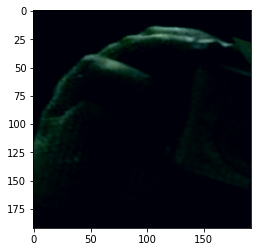

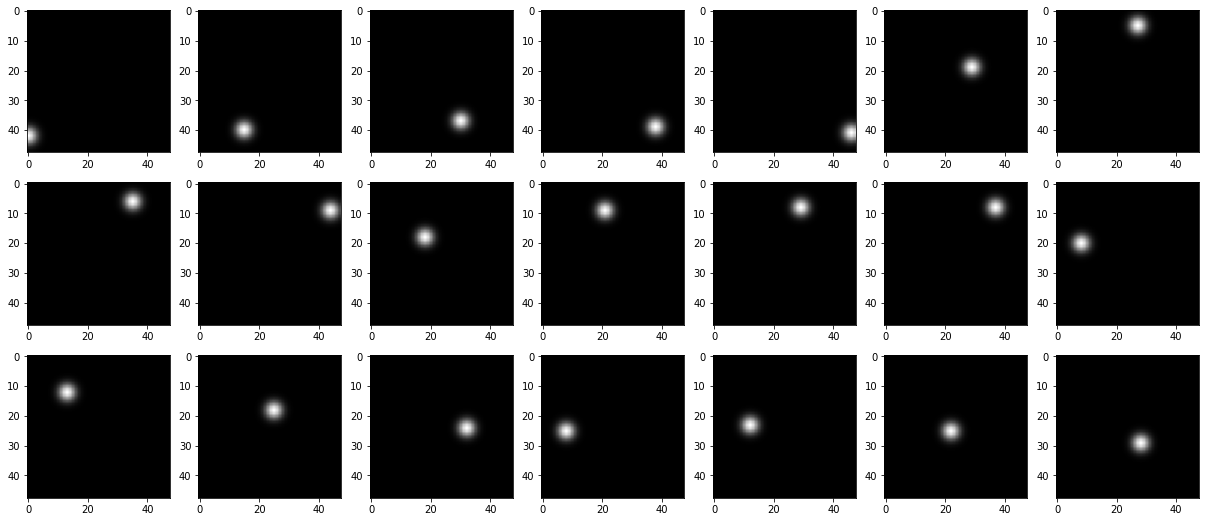

In [ ]:
# Plot image and its heatmaps
ind = 0

test_img = test_data['I'][ind].permute(1,2,0).numpy()*0.226 + 0.45
test_target = test_data['HM'][ind].numpy()

plt.imshow(test_img)
plt.show()

columns = 7
rows = NUM_JOINTS // columns if NUM_JOINTS % columns == 0 else NUM_JOINTS // columns + 1

fig, ax = plt.subplots(rows, columns, figsize=(columns*3, rows*3))

for i in range(rows):
  for j in range(columns):
    
    ax[i,j].imshow(test_target[i*columns + j], plt.cm.gray)
  
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.02864629 0.6823305


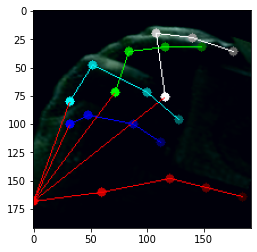

In [ ]:
# Plot keypoint on image
preds, maxvals = process_heatmap(test_target, 0.9)
plot_keypoints(test_img, preds, maxvals)

In [ ]:
# Get model prediction
test_model.eval()
preds = test_model(test_data['I'])
preds.shape

torch.Size([16, 21, 48, 48])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.02864629 0.6823305


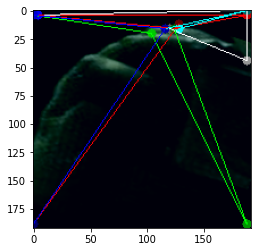

In [ ]:
# Plot predicted keypoints
preds_numpy = preds.detach().numpy()[ind]
hm_preds, maxvals = process_heatmap(preds_numpy, 0)
plot_keypoints(test_img, hm_preds, maxvals)

In [ ]:
# Plot batch statistic
target = test_data['HM'].detach().numpy()
output = preds.detach().numpy()
acc, avg_acc, cnt, pred = accuracy(output, target, hm_type='gaussian', thr=2)
print(acc)
print(avg_acc)
print(cnt)
# print(pred)

[0.07083393 0.08333333 0.         0.         0.09090909 0.18181818
 0.         0.16666667 0.07142857 0.18181818 0.         0.15384615
 0.08333333 0.23076923 0.         0.         0.07692308 0.
 0.         0.         0.08333333 0.08333333]
0.07083392797678512
21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


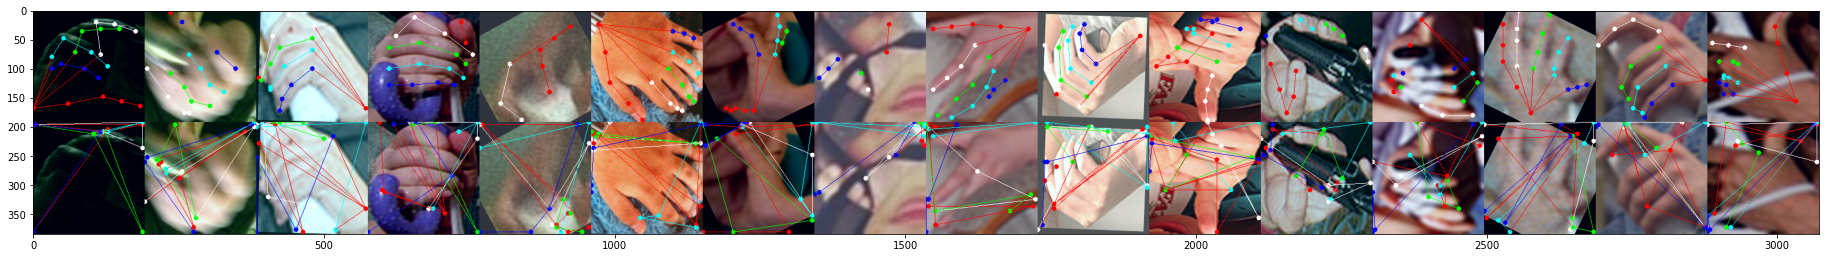

In [ ]:
# Plot batch results
images = test_data['I'].detach().permute(0,2,3,1).cpu().numpy()*0.225 + 0.456
gt_heatmaps = test_data['HM'].detach().cpu().numpy()
pred_heatmaps = preds.detach().cpu().numpy()
pred_img = np.zeros((IMAGE_SIZE[0]*2, IMAGE_SIZE[1]*BATCH_SIZE, 3))

for i in range(BATCH_SIZE):

  o_preds, o_maxvals = process_heatmap(gt_heatmaps[i], 0.0)
  p_preds, p_maxvals = process_heatmap(pred_heatmaps[i], 0.0)
  original_img = plot_keypoints(images[i], o_preds, o_maxvals)
  predicted_img = plot_keypoints(images[i], p_preds, p_maxvals)

  tmp_img = np.concatenate((original_img, predicted_img), axis=0)

  pred_img[:,i*IMAGE_SIZE[1]:i*IMAGE_SIZE[1]+IMAGE_SIZE[1],:] = tmp_img

fig = plt.figure(figsize=(BATCH_SIZE*2, 8))
plt.imshow(pred_img)
plt.show()

# Training

### Validation keypoints load

In [ ]:
# Load .csv file
df = pd.read_csv('/content/drive/MyDrive/pose_estimation/val.csv')
df.head()

,image_name,hand_boxes,hand_keypoints
0,000000425226.jpg,"[304.2, 204.65, 68.03000000000003, 42.57999999...","[308.0, 239.0, 0.1408521831035614, 321.0, 226...."
1,000000458992.jpg,"[330.59, 313.06, 91.80000000000001, 76.4100000...","[391.0, 311.0, 0.017855476588010788, 372.5, 33..."
2,000000458992.jpg,"[-20.2, 308.56, 92.57000000000001, 87.51999999...","[10.0, 323.0, 0.09969476610422134, 22.0, 355.0..."
3,000000031817.jpg,"[213.72, 165.49, 57.47999999999999, 40.9599999...","[252.0, 182.0, 0.011041253805160522, 238.5, 18..."
4,000000182611.jpg,"[266.69, 233.57, 60.78000000000003, 38.2400000...","[271.0, 243.0, 0.08970954269170761, 286.0, 246..."


In [ ]:
# Convert dataframe to numpy
data_numpy = df.to_numpy()
data_numpy.shape

(1051, 3)

In [ ]:
# Read str lines
images_names = data_numpy[:,0]
bboxes = get_info(data_numpy[:,1])
keypoints = get_info(data_numpy[:,2])
keypoints, visibility = correct_visibility(keypoints)

images_names = np.array(images_names)
bboxes = np.array(bboxes)
keypoints = np.array(keypoints)
visibility = np.array(visibility)

In [ ]:
# Get unique filenames
unique_filenames, filenames_counts = np.unique(images_names, return_counts=True)
print(len(unique_filenames))

609


In [ ]:
# Get only not intersected bboxes
bboxes_sorted = []
filenames_sorted = []
keypoints_sorted = []
visibility_sorted = []

for filename in unique_filenames:

  file_name_ind = np.where(images_names == filename)[0]
  tmp_bboxes = bboxes[file_name_ind].copy()
  tmp_keypoints = keypoints[file_name_ind].copy()
  tmp_visibility = visibility[file_name_ind].copy()
  del_ind = calc_iou(tmp_bboxes, 0.3)

  for ind in range(len(tmp_bboxes)):
    if ind in del_ind:
      continue
    else:
      filenames_sorted.append(filename)
      bboxes_sorted.append(tmp_bboxes[ind])
      keypoints_sorted.append(tmp_keypoints[ind])
      visibility_sorted.append(tmp_visibility[ind])


images_names_val = np.array(filenames_sorted)
bboxes_val = np.array(bboxes_sorted)
keypoints_val = np.array(keypoints_sorted)
visibility_val = np.array(visibility_sorted)

In [ ]:
# Create val data dictionary
data_dict_val = {'images_names': images_names_val,
                 'bboxes': bboxes_val,
                 'keypoints': keypoints_val,
                 'visibility': visibility_val}

In [ ]:
!unzip -q /content/drive/MyDrive/pose_estimation/hands_val.zip -d '/content/val_images/'

In [ ]:
# Path to val images
images_path_val = '/content/val_images/hands_val/'

### Train keypoints load

In [ ]:
# Load .csv file
df = pd.read_csv('/content/drive/MyDrive/pose_estimation/train.csv')
df.head()

,image_name,hand_boxes,hand_keypoints
0,000000184659.jpg,"[380.04, 93.93, 101.64999999999998, 71.06]","[477.0, 138.0, 0.2964617609977722, 464.0, 123...."
1,000000184659.jpg,"[366.14, 47.58, 93.93, 89.61]","[453.0, 69.0, 0.1306665688753128, 431.5, 89.0,..."
2,000000457254.jpg,"[292.85, 328.08, 81.5, 70.88]","[297.0, 344.0, 0.07652954012155533, 317.0, 340..."
3,000000064909.jpg,"[254.84, 432.13, 48.72, 47.56]","[289.0, 442.0, 0.05950009822845459, 277.5, 451..."
4,000000064909.jpg,"[213.33, 317.39, 61.109999999999985, 52.759999...","[214.0, 344.0, 0.13771122694015503, 231.5, 333..."


In [ ]:
# Convert dataframe to numpy
data_numpy = df.to_numpy()
data_numpy.shape

(27700, 3)

In [ ]:
# Read str lines
images_names = data_numpy[:,0]
bboxes = get_info(data_numpy[:,1])
keypoints = get_info(data_numpy[:,2])
keypoints, visibility = correct_visibility(keypoints)

images_names = np.array(images_names)
bboxes = np.array(bboxes)
keypoints = np.array(keypoints)
visibility = np.array(visibility)

In [ ]:
# Get only not intersected bboxes
unique_filenames, filenames_counts = np.unique(images_names, return_counts=True)
print(len(unique_filenames))

16107


In [ ]:
# Get only not intersected bboxes
bboxes_sorted = []
filenames_sorted = []
keypoints_sorted = []
visibility_sorted = []

for filename in unique_filenames:

  file_name_ind = np.where(images_names == filename)[0]
  tmp_bboxes = bboxes[file_name_ind].copy()
  tmp_keypoints = keypoints[file_name_ind].copy()
  tmp_visibility = visibility[file_name_ind].copy()
  del_ind = calc_iou(tmp_bboxes, 0.3)

  for ind in range(len(tmp_bboxes)):
    if ind in del_ind:
      continue
    else:
      filenames_sorted.append(filename)
      bboxes_sorted.append(tmp_bboxes[ind])
      keypoints_sorted.append(tmp_keypoints[ind])
      visibility_sorted.append(tmp_visibility[ind])


images_names_train = np.array(filenames_sorted)
bboxes_train = np.array(bboxes_sorted)
keypoints_train = np.array(keypoints_sorted)
visibility_train = np.array(visibility_sorted)

In [ ]:
# Create train data dictionary
data_dict_train = {'images_names': images_names_train,
                   'bboxes': bboxes_train,
                   'keypoints': keypoints_train,
                   'visibility': visibility_train}

In [ ]:
!unzip -q /content/drive/MyDrive/pose_estimation/hands_train.zip -d '/content/train_images/'

In [ ]:
# Path to train images
images_path_train = '/content/train_images/hands_train/'

### Training

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/pose_estimation/hands/version1/checkpoint/'
VIS_DIR = '/content/drive/MyDrive/pose_estimation/hands/version1/vis_dir/'

In [ ]:
# Create dataloaders
train_transform = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.5, border_mode=cv2.BORDER_CONSTANT),
     A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
     A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

train_dataset = JiontsDataset(data_dict_train, images_path_train, train_transform)

val_transform = A.Compose(
    [
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

val_dataset = JiontsDataset(data_dict_val, images_path_val, val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [ ]:
trainer_for_hands = HandsTrainer(dataloaders)

In [ ]:
trainer_for_hands.net

PoseHighResolutionNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

posx and posy should be finite values


Epoch 79 / 139, Epoch_acc=0.7039, Historical_best_acc=0.7075 (at epoch 78)
Epoch time 7 min


posx and posy should be finite values


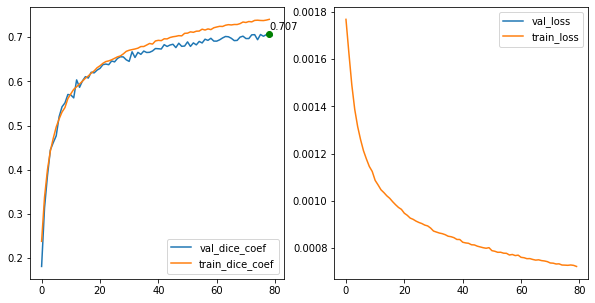

In [ ]:
trainer_for_hands.train_models()

In [ ]:
# Create dataloaders
# Add blur augmentation
train_transform = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     A.Blur(blur_limit=12, p=0.8),
     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.5, border_mode=cv2.BORDER_CONSTANT),
     A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
     A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

train_dataset = JiontsDataset(data_dict_train, images_path_train, train_transform)

val_transform = A.Compose(
    [
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

val_dataset = JiontsDataset(data_dict_val, images_path_val, val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/pose_estimation/hands/version1/checkpoint/'
VIS_DIR = '/content/drive/MyDrive/pose_estimation/hands/version1/vis_dir_blur/'
END_EPOCH = 250

posx and posy should be finite values


Epoch 235 / 249, Epoch_acc=0.7260, Historical_best_acc=0.7308 (at epoch 229)
Epoch time 6 min


posx and posy should be finite values


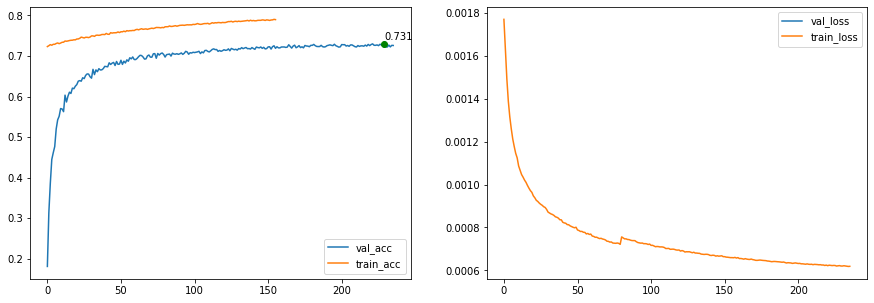

In [ ]:
trainer_for_hands = HandsTrainer(dataloaders)
trainer_for_hands.train_models()

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/pose_estimation/hands/version1/checkpoint/'
VIS_DIR = '/content/drive/MyDrive/pose_estimation/hands/version1/vis_dir_blur/'
END_EPOCH = 350

posx and posy should be finite values


Epoch 325 / 349, Epoch_acc=0.7323, Historical_best_acc=0.7334 (at epoch 317)
Epoch time 6 min


posx and posy should be finite values


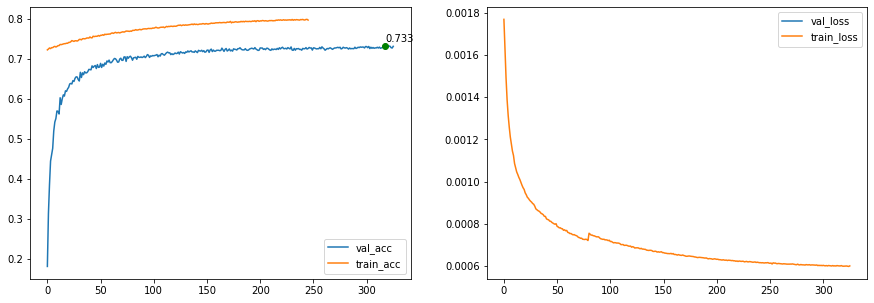

In [ ]:
trainer_for_hands = HandsTrainer(dataloaders)
trainer_for_hands.train_models()